- BCI: brain computer interface, reads brain signals
  - people that are paralyzed can control a computer with their brain signals
  - with their brain signals, Theo wants to see how focused someone is / see their emotions
  - just did a project at home last week where Theo built a BCI (bought sensors, coded something to filter the data, classify each mental state)
  - all the companies that do this use AI to notice patterns in the data & such, trying to get more practice using AI with the brain data
  - watched 15 minute video of guy coding AI with cancer data



In [3]:
import scipy.io # importing this will help us get the .mat files in
import pandas as pd
import numpy as np

# all this is to get the raw data into a usable format

channel_names = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2',
                 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']

filename = ["eeg_record", ".mat"]






In [ ]:
for i in range(1,35):
  current_filename = filename[0] + str(i)
  mat = scipy.io.loadmat("bci_data/" + current_filename + filename[1])
  raw_data = mat['o']['data'][0, 0]
  eeg_data = raw_data[:, 3:17]
  eeg_df = pd.DataFrame(eeg_data, columns = channel_names)
  sampling_frequency = 128  # Hz
  eeg_df['Time (s)'] = np.arange(0, eeg_data.shape[0]) / sampling_frequency
  eeg_df.to_csv("csv_data/" + current_filename + ".csv")

- key terms:
  - linear regression: y as our response variable (dependent), a bunch of x's (x1, x2, x3, ..., xn) that are predictor variables (independent)
    - assuming a linear relationship, we hope to find some coefficients B0, B1, B2, ... Bn such that we can create a linear function y = B0 + B1x1 + B2x2 + B3x3 + ... + Bnxn
    

- game plan:
  - convert all the .mat files to .csv
  - feed the .csv files into chatgpt to get it to give all the data a classification (doesn't matter if it's right for now)
  - use the classified data to train a few models!
    - linear regression
    - polynomial regression
    - knn

# WRONGGGGGGGG BELOW IS SO WRONG

In [2]:
#import mne
from scipy.signal import welch

# Load EEG data
eeg_df = pd.read_csv('csv_data/eeg_record1.csv')

# Define frequency bands
bands = {
    'delta': (0.5, 4),
    'theta': (4, 8),
    'alpha': (8, 13),
    'beta': (13, 30)
}

# Sampling frequency
sf = 128  # Hz


# Function to compute band power
def bandpower(data, sf, band, window_sec=1):
    band = np.asarray(band)
    low, high = band

    #nperseg = int(sf * window_sec)
    #nperseg = min(len(data), sf)
    nperseg = min(len(data), int(sf * window_sec))

    # Compute the modified periodogram (Welch)
    freqs, psd = welch(data, sf, nperseg=nperseg)

    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Find index of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)


    # Integral approximation of the spectrum using Simpson's rule.
    band_power = np.trapz(psd[idx_band], dx=freq_res)
    return band_power

'''

# Initialize list to store classifications
classifications = []



# Iterate over each row (time point) in the DataFrame
for index, row in eeg_df.iterrows():
    # Extract EEG data (assuming columns 1 to 14 are EEG channels)
    eeg_data = row[1:15].values

    # Compute band powers
    band_powers = {band: bandpower(eeg_data, sf, bands[band]) for band in bands}
    print(band_powers)

    # Classification logic
    if band_powers['beta'] > band_powers['alpha'] and band_powers['beta'] > band_powers['theta']:
        state = 'focused'
    elif band_powers['alpha'] > band_powers['beta']:
        state = 'unfocused'
    elif band_powers['theta'] > band_powers['alpha'] and band_powers['theta'] > band_powers['beta']:
        state = 'drowsy'
    else:
        state = 'unclassified'

    classifications.append(state)

# Add classifications to DataFrame
eeg_df['Attention_State'] = classifications


# Save to new CSV
eeg_df.to_csv('csv_classified_data/eeg_record1_classified.csv', index=False)
'''

# Initialize list to store classifications
classifications = []

# Define a window size for data aggregation (e.g., 128 samples for 1 second)
window_size = 128  # Number of rows to aggregate

# Initialize list to store classifications for the entire DataFrame
attention_states = []

# Process segments
for start in range(0, len(eeg_df), window_size):
    # Extract the segment
    segment = eeg_df.iloc[start:start + window_size, 1:15].values.flatten()

    # Skip short segments
    if len(segment) < window_size * 14:
        continue

    # Compute band powers and classify
    band_powers = {band: bandpower(segment, sf, bands[band]) for band in bands}
    if band_powers['beta'] > band_powers['alpha'] and band_powers['beta'] > band_powers['theta']:
        state = 'focused'
    elif band_powers['alpha'] > band_powers['beta']:
        state = 'unfocused'
    elif band_powers['theta'] > band_powers['alpha'] and band_powers['theta'] > band_powers['beta']:
        state = 'drowsy'
    else:
        state = 'unclassified'

    # Append the classification for each row in the segment
    attention_states.extend([state] * window_size)

# Ensure the output matches the DataFrame length
attention_states = attention_states[:len(eeg_df)]  # Truncate if too long

# Truncate the DataFrame to match the length of classifications
truncated_eeg_df = eeg_df.iloc[:len(attention_states)].copy()

# Assign the classifications to the truncated DataFrame
truncated_eeg_df['Attention_State'] = attention_states

# Save the truncated DataFrame
truncated_eeg_df.to_csv('csv_classified_data/eeg_record1_classified.csv', index=False)

In [13]:
# classify all 34 csvs

filename = ["eeg_record", ".csv"]


for i in range(1,35):
    current_filename = filename[0] + str(i) + filename[1]
    eeg_df = pd.read_csv('csv_data/' + current_filename)
    classifications = []
    # Define a window size for data aggregation (e.g., 128 samples for 1 second)
    window_size = 128  # Number of rows to aggregate

    # Initialize list to store classifications for the entire DataFrame
    attention_states = []

    # Process segments
    for start in range(0, len(eeg_df), window_size):
        # Extract the segment
        segment = eeg_df.iloc[start:start + window_size, 1:15].values.flatten()

        # Skip short segments
        if len(segment) < window_size * 14:
            continue

        # Compute band powers and classify
        band_powers = {band: bandpower(segment, sf, bands[band]) for band in bands}
        if band_powers['beta'] > band_powers['alpha'] and band_powers['beta'] > band_powers['theta']:
            state = 'focused'
        elif band_powers['alpha'] > band_powers['beta']:
            state = 'unfocused'
        elif band_powers['theta'] > band_powers['alpha'] and band_powers['theta'] > band_powers['beta']:
            state = 'drowsy'
        else:
            state = 'unclassified'

        # Append the classification for each row in the segment
        attention_states.extend([state] * window_size)
        
    # Ensure the output matches the DataFrame length
    attention_states = attention_states[:len(eeg_df)]  # Truncate if too long

    # Truncate the DataFrame to match the length of classifications
    truncated_eeg_df = eeg_df.iloc[:len(attention_states)].copy()

    
    truncated_eeg_df['Attention_State'] = attention_states
    truncated_eeg_df.to_csv('csv_classified_data/' + filename[0] + str(i) + "_classified.csv", index=False)

# RIGHTTTTT BELOW IS RIGHT

In [9]:
eeg_df = pd.read_csv('csv_data/eeg_record1.csv')
eeg_df.head()

total_rows = len(eeg_df)

focused_end = 10 * 60 * 128
unfocused_end = 20 * 60 * 128

eeg_df['Attention_State'] = 'drowsy'
eeg_df.loc[:focused_end, 'Attention_State'] = 'focused'
eeg_df.loc[focused_end:unfocused_end, 'Attention_State'] = 'unfocused'

eeg_df.head()

eeg_df.to_csv('csv_classified_data/eeg_record1_classified.csv', index=False)



In [10]:
filename = ["eeg_record", ".csv"]

for i in range(1,35):
    current_filename = filename[0] + str(i) + filename[1]
    eeg_df = pd.read_csv('csv_data/' + current_filename)

    eeg_df['Attention_State'] = 'drowsy'
    eeg_df.loc[:focused_end, 'Attention_State'] = 'focused'
    eeg_df.loc[focused_end:unfocused_end, 'Attention_State'] = 'unfocused'

    eeg_df.to_csv('csv_classified_data/' + filename[0] + str(i) + "_classified.csv", index=False)

In [11]:
# logistic regression
# new package called sklearn which is good for a lot of statistical models

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import classification_report


# we'll split the data into a training portion that the model will be trained on, and a testing portion that we will use to evaluate it

data = pd.read_csv('csv_classified_data/eeg_record1_classified.csv')
X = data.drop(['Attention_State', 'Time (s)'], axis=1)
y = data['Attention_State']

X_train, X_test, y_train, y_test = train_test_split (X, y, test_size=0.2, random_state=42)

model = LogisticRegression() # creates the object for the logistic regression model
model.fit(X_train, y_train) # trains the model based on the training data

y_pred = model.predict(X_test) # uses the model to predict y values for the test data

print(classification_report(y_test, y_pred)) # compares the predicted y values to the actual y values for the test data



/Users/lukeyang/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

      drowsy       1.00      1.00      1.00     31206
     focused       1.00      1.00      1.00     15298
   unfocused       1.00      1.00      1.00     15270

    accuracy                           1.00     61774
   macro avg       1.00      1.00      1.00     61774
weighted avg       1.00      1.00      1.00     61774



1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
Best k: 2


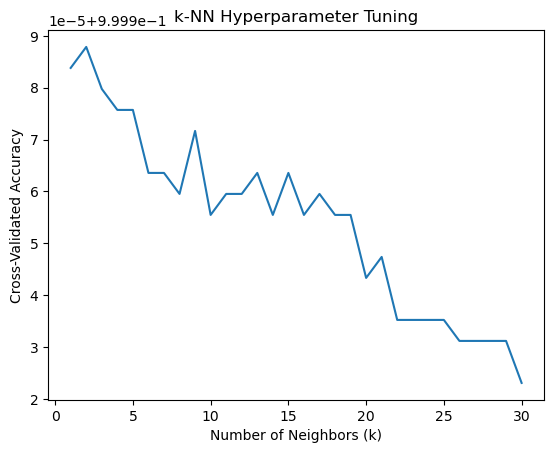

              precision    recall  f1-score   support

      drowsy       1.00      1.00      1.00     31206
     focused       1.00      1.00      1.00     15298
   unfocused       1.00      1.00      1.00     15270

    accuracy                           1.00     61774
   macro avg       1.00      1.00      1.00     61774
weighted avg       1.00      1.00      1.00     61774



NameError: name 'accuracy_score' is not defined

In [13]:
# knn model
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

k_values = range(1, 31)  # Test k from 1 to 30
cv_scores = [] 

for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')  # 5-fold CV
    cv_scores.append(scores.mean())
    print(k)
    
# Find the k with the highest cross-validation accuracy
best_k = k_values[np.argmax(cv_scores)]
print(f"Best k: {best_k}")

# Plot the results
import matplotlib.pyplot as plt
plt.plot(k_values, cv_scores)
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Cross-Validated Accuracy')
plt.title('k-NN Hyperparameter Tuning')
plt.show()

model = KNeighborsClassifier(n_neighbors=best_k)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

# Define the model with k=1
model = KNeighborsClassifier(n_neighbors=1)

# Train the model on the training set
model.fit(X_train, y_train)

# Predict on the test set
y_test_pred = model.predict(X_test)

# Evaluate performance on the test set
print("Accuracy on Test Set:", accuracy_score(y_test, y_test_pred))
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_test_pred))